In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# ——————————————
# 全局设置：支持中文 & 负号
# ——————————————
plt.rcParams['font.sans-serif'] = ['SimHei']      # 或者你的系统里其他可用中文字体
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# —— 0. 读取 & 转换日期列 ——
df = pd.read_csv("dataset_clean.csv")
df["submit_datatime"]  = pd.to_datetime(df["submit_datatime"])
df["player_birthday"]  = pd.to_datetime(df["player_birthday"])

# —— 1.1 派生年龄相关变量 ——
# current_age：直接相减得到 timedelta，再 .dt.days
df["current_age"]      = (df["submit_datatime"] - df["player_birthday"]).dt.days / 365.25
df["experience_yrs"]   = df["play_time_month"] / 12
df["start_age"]        = df["current_age"] - df["experience_yrs"]

# —— 1.2 练习强度指标 ——
df["plays_per_month"]  = df["play_count"] / df["play_time_month"].clip(lower=1)
df["plays_per_year"]   = df["play_count"] / df["experience_yrs"].clip(lower=0.1)

# —— 1.3 标准化打分 ——
df["rating_z"] = (df["player_rating"] - df["player_rating"].mean()) / df["player_rating"].std()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   player_name      347 non-null    object        
 1   submit_datatime  347 non-null    datetime64[ns]
 2   player_rating    347 non-null    int64         
 3   Question1        347 non-null    int64         
 4   player_birthday  347 non-null    datetime64[ns]
 5   Question2        347 non-null    int64         
 6   play_time_month  347 non-null    int64         
 7   play_count       347 non-null    int64         
 8   Question3        163 non-null    object        
 9   current_age      347 non-null    float64       
 10  experience_yrs   347 non-null    float64       
 11  start_age        347 non-null    float64       
 12  plays_per_month  347 non-null    float64       
 13  plays_per_year   347 non-null    float64       
 14  rating_z         347 non-null    float64  

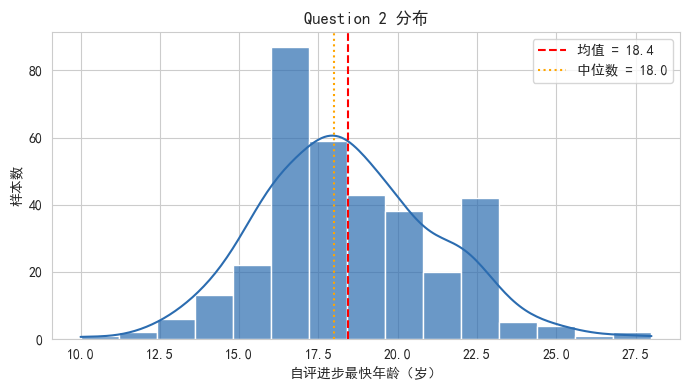

In [13]:
# ① 清洗：去除缺失 & >30 的异常值
q2_clean = df["Question2"].dropna()
q2_clean = q2_clean[q2_clean <= 30]

# ② 可视化：直方图 + KDE
plt.figure(figsize=(7,4))
sns.histplot(q2_clean, bins=15, kde=True, color="#2b6cb0", alpha=0.7)
plt.axvline(q2_clean.mean(), color="red", ls="--", label=f"均值 = {q2_clean.mean():.1f}")
plt.axvline(q2_clean.median(), color="orange", ls=":", label=f"中位数 = {q2_clean.median():.1f}")

plt.xlabel("自评进步最快年龄（岁）")
plt.ylabel("样本数")
plt.title("Question 2 分布")
plt.legend()
plt.tight_layout()
plt.show()


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\24425\AppData\Local\Temp\jieba.cache
Loading model cost 0.824 seconds.
Prefix dict has been built successfully.


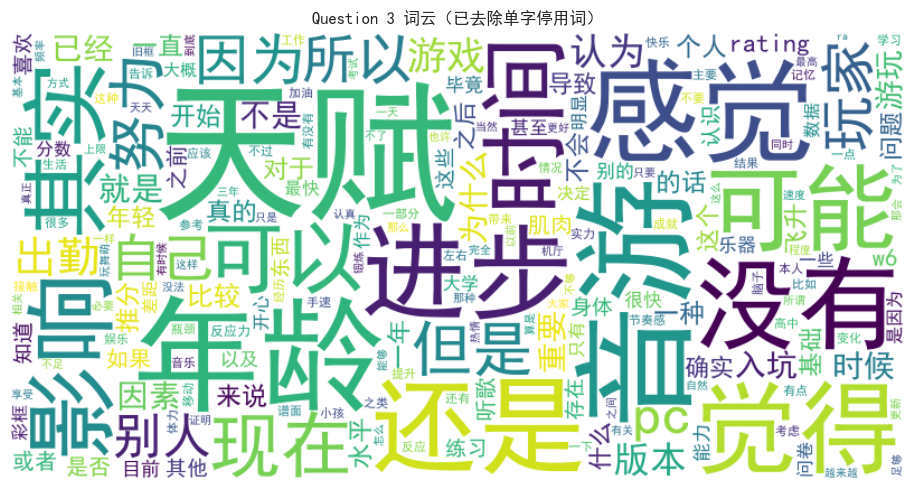

In [4]:
from wordcloud import WordCloud
import jieba
# ① 合并文本
text_all = " ".join(df["Question3"].dropna().astype(str))

# ② 分词
words = jieba.lcut(text_all, cut_all=False)

# ③ 构造停用词：常见助词 + 所有 1 个汉字长度的词
common_stop = {"我", "你", "他", "她", "了", "的", "吧", "啊", "嘛", "呢",
               "就", "也", "很", "都", "还", "在", "和", "跟", "一个","舞萌"}
stopwords  = common_stop.union({w for w in words if len(w) == 1})

# ④ 过滤停用词
words_filt = [w for w in words if w not in stopwords]
text_seg   = " ".join(words_filt)

# ⑤ 生成词云
font_path = "C:/Windows/Fonts/simhei.ttf"  # ← 请替换为实际中文字体路径
wc = WordCloud(
    width=800, height=400,
    background_color="white",
    font_path=font_path,
    max_words=200,
    collocations=False
).generate(text_seg)

# ⑥ 可视化
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Question 3 词云（已去除单字停用词）")
plt.tight_layout()
plt.show()

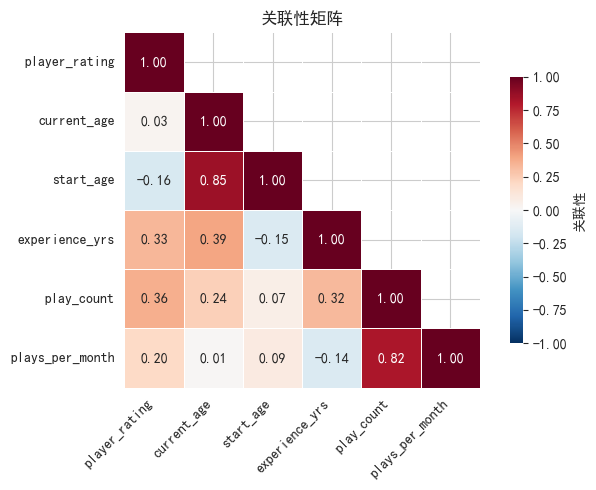

In [5]:

# —— 2.2 精简 & 美化的相关矩阵热图 ——
features = [
    "player_rating",
    "current_age",
    "start_age",
    "experience_yrs",
    "play_count",
    "plays_per_month"
]

# 计算相关矩阵
corr = df[features].corr()

# 只保留下三角
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)


plt.figure(figsize=(7,5))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75, "label": "关联性"}
)

# 美化坐标与标题
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("关联性矩阵")
plt.tight_layout()
plt.show()


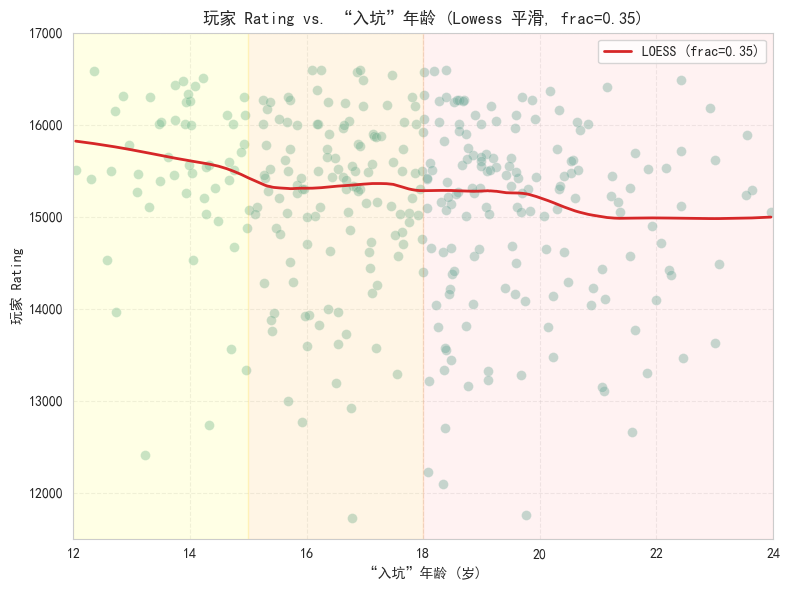

In [6]:
# —— 2.3 Rating vs. Start Age （Lowess）——
from statsmodels.nonparametric.smoothers_lowess import lowess

# 只保留 12–24 岁区间
df2 = df.query("start_age >= 12 and start_age <= 24")

# 1. 画散点
plt.figure(figsize=(8,6))
plt.scatter(
    df2["start_age"],
    df2["player_rating"],
    s=50,
    alpha=0.4,
    color="#69b3a2",
    edgecolor="w",
    linewidth=0.3
)

# 2. 计算 LOESS（frac=0.35）
loess_sm = lowess(
    endog=df2["player_rating"],
    exog=df2["start_age"],
    frac=0.35,
    return_sorted=True
)

# 3. 绘制平滑曲线
plt.plot(
    loess_sm[:,0], loess_sm[:,1],
    color="#d62728",
    linewidth=2,
    label="LOESS (frac=0.35)"
)


# 4. 美化
plt.xlim(12, 24)
plt.ylim(11500, 17000)
plt.xlabel("“入坑”年龄 (岁)")
plt.ylabel("玩家 Rating")
plt.title("玩家 Rating vs. “入坑”年龄 (Lowess 平滑, frac=0.35)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.axvspan(12, 15, color="yellow", alpha=0.1)
plt.axvspan(15, 18, color="orange", alpha=0.1)
plt.axvspan(18, 24, color="red", alpha=0.05)

plt.tight_layout()
plt.show()


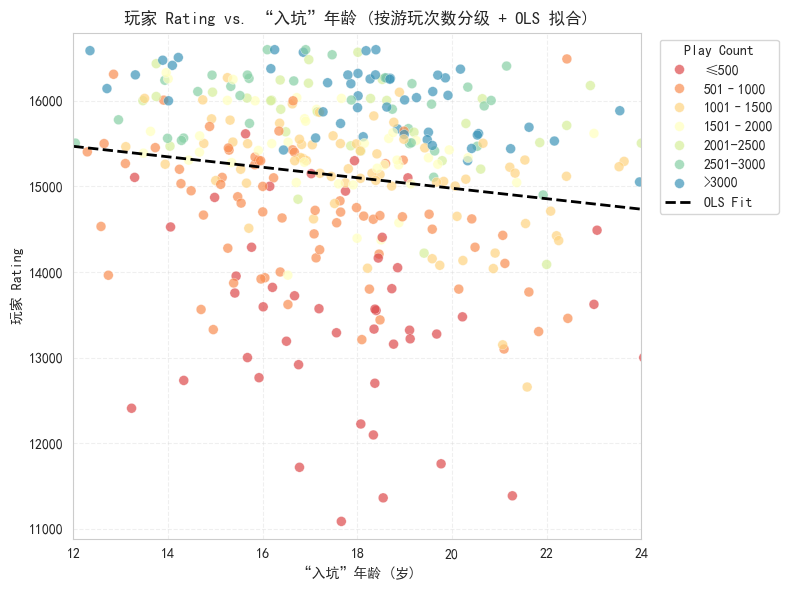

In [7]:
#=======================
# 方案 3：分段上色 & OLS 回归
#=======================
import statsmodels.api as sm

# 假设 df 已包含 start_age, player_rating, play_count

# 1) 对 play_count 进行分箱
bins   = [0, 500, 1000, 1500, 2000, 2500, 3000, np.inf]
labels = ["≤500", "501–1000", "1001–1500", "1501–2000", "2001-2500","2501-3000",">3000"]
df["pc_cat"] = pd.cut(df["play_count"], bins=bins, labels=labels, right=True)

# 2) 绘图
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="start_age",
    y="player_rating",
    hue="pc_cat",
    palette="Spectral",
    alpha=0.7,
    s=50,
    edgecolor="w",
    linewidth=0.3
)

# 3) 叠加 OLS 线性拟合
X = sm.add_constant(df["start_age"])
ols = sm.OLS(df["player_rating"], X).fit()
x0 = np.linspace(12, 24, 100)
y0 = ols.params["const"] + ols.params["start_age"] * x0
plt.plot(x0, y0, color="black", linestyle="--", linewidth=2, label="OLS Fit")

# 4) 美化与注释
plt.xlim(12, 24)
plt.ylim(df["player_rating"].min() - 200, df["player_rating"].max() + 200)
plt.xlabel("“入坑”年龄 (岁)")
plt.ylabel("玩家 Rating")
plt.title("玩家 Rating vs. “入坑”年龄 (按游玩次数分级 + OLS 拟合)")

# 调整图例
plt.legend(title="Play Count", bbox_to_anchor=(1.02,1), loc="upper left", frameon=True)

plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

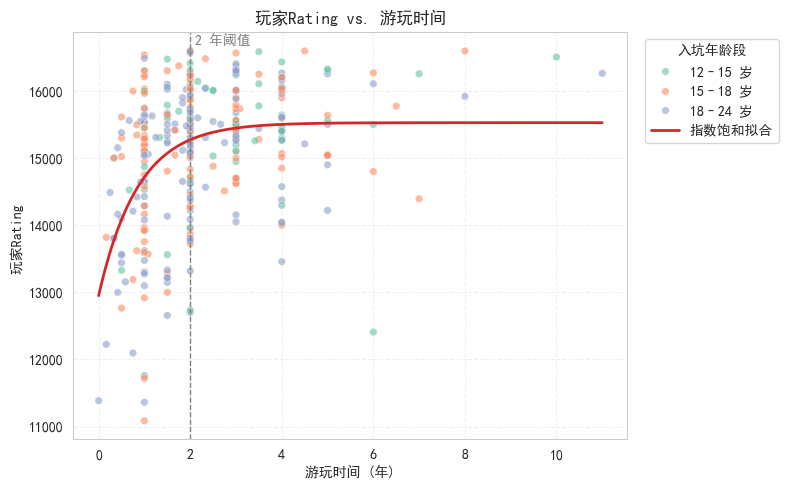

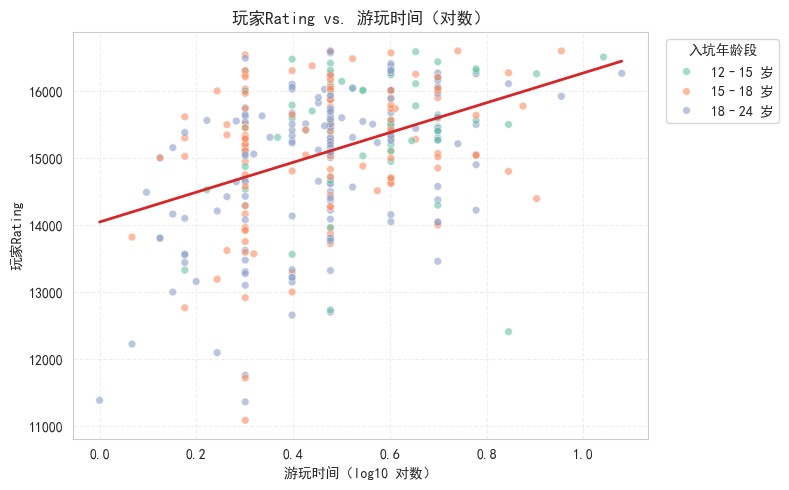

In [8]:

from scipy.optimize import curve_fit
plt.rcParams.update({
    "font.sans-serif": ["SimHei"],    # 支持中文
    "axes.unicode_minus": False       # 负号正常显示
})
# ——————————————————————————————
# 图 1：原始散点 + 指数饱和拟合（提示饱和趋势）
# y = a*(1 - exp(-b*x)) + c
# ——————————————————————————————
df["log_time"] = np.log10(df["experience_yrs"] + 1)

# 按入坑年龄分组
df["age_group"] = pd.cut(
    df["start_age"],
    bins=[0, 15, 18, 30],
    labels=["12–15 岁", "15–18 岁", "18–24 岁"]
)

# 定义饱和函数
def saturating(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

# 拟合参数
popt, _ = curve_fit(
    saturating,
    df["experience_yrs"],
    df["player_rating"],
    p0=[5000, 1, 10000],
    maxfev=10000
)

# 饱和拟合曲线
x_fit = np.linspace(0, df["experience_yrs"].max(), 200)
y_fit = saturating(x_fit, *popt)

# —— 图 1：指数饱和 拟合（点按年龄分色） ——
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df, x="experience_yrs", y="player_rating",
    hue="age_group", palette="Set2",
    s=30, alpha=0.6
)
plt.plot(x_fit, y_fit, color="#d62728", lw=2, label="指数饱和拟合")
plt.axvline(2, color="gray", linestyle="--", lw=1)
plt.text(2.1, plt.ylim()[1]-200, "2 年阈值", color="gray")

plt.xlabel("游玩时间 (年)")
plt.ylabel("玩家Rating ")
plt.title("玩家Rating vs. 游玩时间")
plt.legend(title="入坑年龄段", bbox_to_anchor=(1.02,1), loc="upper left")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


# —— 图 2：对数坐标 + 线性拟合（点按年龄分色） ——
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df, x="log_time", y="player_rating",
    hue="age_group", palette="Set2",
    s=30, alpha=0.6
)
sns.regplot(
    data=df, x="log_time", y="player_rating",
    scatter=False, ci=None, color="#d62728", line_kws={"lw":2}
)

plt.xlabel("游玩时间（log10 对数）")
plt.ylabel("玩家Rating")
plt.title("玩家Rating vs. 游玩时间（对数）")
plt.legend(title="入坑年龄段", bbox_to_anchor=(1.02,1), loc="upper left")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

In [9]:
# —— 3.1 回归：基准模型（加入 play_count） ——
m0 = smf.ols(
    "player_rating ~ play_time_month + play_count",
    data=df
).fit()
print("\nBaseline model (m0):")
print(m0.summary())

# —— 3.2 加入年龄项 ——
m1 = smf.ols(
    "player_rating ~ play_time_month + play_count + current_age + start_age",
    data=df
).fit()
print("\nCompare m1 vs m0 (F-test ΔR²):", m1.compare_f_test(m0))
print(m1.summary())

# —— 3.3 交互：start_age × play_count ——
m2 = smf.ols(
    "player_rating ~ play_time_month + play_count + current_age + start_age + start_age:play_count",
    data=df
).fit()
print("\nInteraction model (m2):")
print(m2.summary())



Baseline model (m0):
                            OLS Regression Results                            
Dep. Variable:          player_rating   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     38.05
Date:                Fri, 20 Jun 2025   Prob (F-statistic):           1.18e-15
Time:                        14:24:52   Log-Likelihood:                -2866.0
No. Observations:                 347   AIC:                             5738.
Df Residuals:                     344   BIC:                             5750.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.4

In [10]:
# -----------------------------
# 0. RF与XGB特征与目标
# -----------------------------
X = df[[
    "play_time_month",
    "play_count",
    "current_age",
    "start_age",
    "plays_per_month",
]].fillna(0)
y = df["player_rating"]


In [11]:


# -----------------------------
# 1. Random Forest + 置换重要度
# -----------------------------
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(n_estimators=500, random_state=42))
])
rf_pipe.fit(X, y)

rf_perm = permutation_importance(
    rf_pipe, X, y,
    n_repeats=10,
    random_state=42,
    scoring="r2",
    n_jobs=-1
)
rf_imp = pd.Series(rf_perm.importances_mean, index=X.columns).sort_values(ascending=False)
print("Random Forest (Permutation Importance)\n", rf_imp, "\n")

Random Forest (Permutation Importance)
 play_count         1.548716
start_age          0.173540
current_age        0.092399
plays_per_month    0.071555
play_time_month    0.030795
dtype: float64 



In [12]:
from xgboost import XGBRegressor, DMatrix

# -----------------------------
# 2. XGBoost + 置换重要度 + 内置 TreeSHAP
# -----------------------------
xgb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        n_estimators=400,
        learning_rate=0.01,
        max_depth=3,
        subsample=0.6,
        colsample_bytree=0.8,
        reg_alpha=1,
        reg_lambda=10,
        objective="reg:squarederror",
        random_state=42
    ))
])
xgb_pipe.fit(X, y)

# 2.1 置换重要度
xgb_perm = permutation_importance(
    xgb_pipe, X, y,
    n_repeats=10,
    random_state=42,
    scoring="r2",
    n_jobs=-1
)
xgb_imp = pd.Series(xgb_perm.importances_mean, index=X.columns).sort_values(ascending=False)
print("XGBoost (Permutation Importance)\n", xgb_imp, "\n")

# -----------------------------
# XGBoost TreeSHAP (修正版)
# -----------------------------
xgb_model  = xgb_pipe.named_steps["xgb"]
X_scaled   = xgb_pipe.named_steps["scaler"].transform(X)

# ① 转成 DMatrix 并带上列名
dmat = DMatrix(X_scaled, feature_names=X.columns.tolist())

# ② 调用底层 Booster 的 predict(pred_contribs=True)
booster = xgb_model.get_booster()
shap_contribs = booster.predict(dmat, pred_contribs=True)

# ③ 去掉最后一列 bias，
shap_vals = shap_contribs[:, :-1]
abs_mean  = np.abs(shap_vals).mean(axis=0)

xgb_shap_imp = pd.Series(abs_mean, index=X.columns).sort_values(ascending=False)
print("XGBoost (TreeSHAP Global Importance)\n", xgb_shap_imp, "\n")



KeyboardInterrupt: 

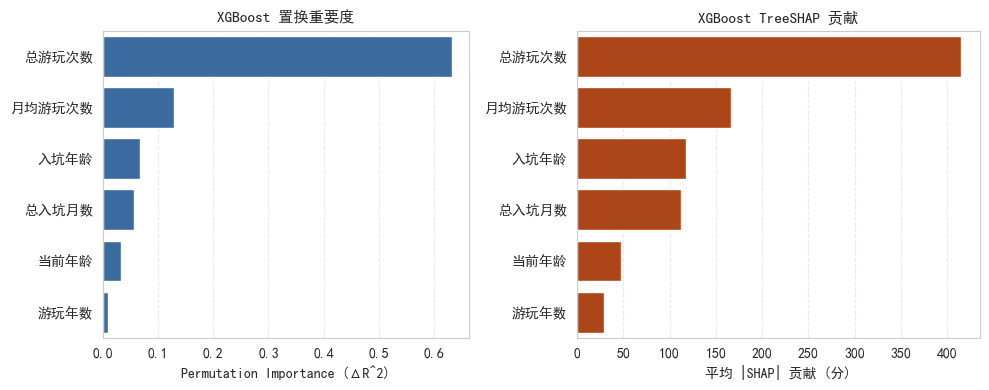

In [48]:
# ========= 新增可视化代码：XGBoost 双栏重要度图 =========
# 0️⃣   中文映射，方便在 PPT 直接展示
cn_name = {
    "play_time_month" : "总入坑月数",
    "play_count"      : "总游玩次数",
    "current_age"     : "当前年龄",
    "start_age"       : "入坑年龄",
    "plays_per_month" : "月均游玩次数",
    "experience_yrs"  : "游玩年数"
}
perm_cn  = xgb_imp.rename(index=cn_name)
shap_cn  = xgb_shap_imp.rename(index=cn_name)

# 1️⃣   统一排序（按置换重要度从高到低）
order = perm_cn.sort_values(ascending=False).index
perm_cn  = perm_cn.loc[order]
shap_cn  = shap_cn.loc[order]

# 2️⃣   画左右两栏：左 = 置换重要度 (ΔR²)，右 = TreeSHAP (分)
plt.figure(figsize=(10, 4))
gs = plt.GridSpec(1, 2, width_ratios=[1, 1.1])

# ——— 左：Permutation Importance ———
ax1 = plt.subplot(gs[0])
sns.barplot(
    x=perm_cn.values, y=perm_cn.index,
    color="#2b6cb0", ax=ax1
)
ax1.set_xlabel("Permutation Importance (ΔR^2)")
ax1.set_ylabel("")
ax1.set_title("XGBoost 置换重要度", fontsize=11)
ax1.grid(axis="x", ls="--", alpha=0.4)

# ——— 右：TreeSHAP Global Importance ———
ax2 = plt.subplot(gs[1], sharey=ax1)
sns.barplot(
    x=shap_cn.values, y=shap_cn.index,
    color="#c43c00", ax=ax2
)
ax2.set_xlabel("平均 |SHAP| 贡献 (分)")
ax2.set_ylabel("")
ax2.set_title("XGBoost TreeSHAP 贡献", fontsize=11)
ax2.grid(axis="x", ls="--", alpha=0.4)

plt.tight_layout()
plt.show()


C:\Users\24425\miniconda3\envs\dtmnenv\Lib\site-packages\sklearn\ensemble\_forest.py:513: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  y_type = type_of_target(y)


OOB R² = 0.590


C:\Users\24425\AppData\Local\Temp\ipykernel_10224\1528154064.py:54: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
C:\Users\24425\AppData\Local\Temp\ipykernel_10224\1528154064.py:61: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\24425\miniconda3\envs\dtmnenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


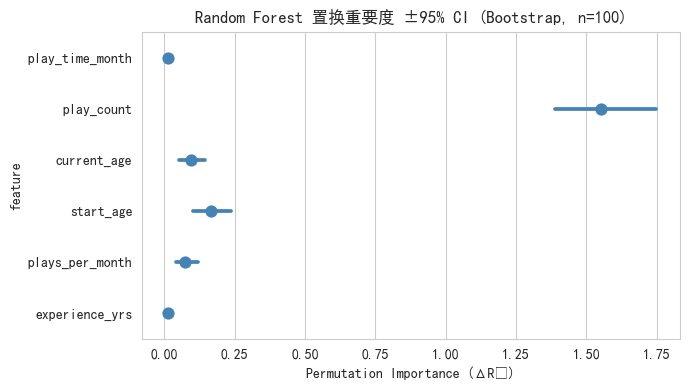

                     mean     lower     upper
feature                                      
play_count       1.553764  1.388235  1.746518
start_age        0.165491  0.103483  0.237707
current_age      0.093669  0.053605  0.145364
plays_per_month  0.073145  0.041213  0.120186
experience_yrs   0.013879  0.007963  0.022151
play_time_month  0.013817  0.008349  0.022665


In [32]:
# -----------------
# 1. 带 OOB 的基准森林
# -----------------
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(
        n_estimators=500,
        oob_score=True,         # 开启 OOB
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ))
])
rf_pipe.fit(X, y)
print(f"OOB R² = {rf_pipe.named_steps['rf'].oob_score_:.3f}")

# -----------------
# 2. Bootstrap 置换重要度：100 次
# -----------------
n_boot = 100
boot_means = []

for seed in range(n_boot):
    # 自助抽样索引
    idx = np.random.RandomState(seed).choice(len(X), len(X), replace=True)
    Xb, yb = X.iloc[idx], y.iloc[idx]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestRegressor(
            n_estimators=300,
            random_state=seed,
            n_jobs=-1
        ))
    ])
    pipe.fit(Xb, yb)

    perm = permutation_importance(
        pipe, Xb, yb, n_repeats=5,
        random_state=seed, scoring="r2"
    )
    boot_means.append(perm.importances_mean)

boot_means = np.vstack(boot_means)                       # (100, n_features)
imp_df = pd.DataFrame(
    boot_means, columns=X.columns
).stack().reset_index()
imp_df.columns = ["iter", "feature", "importance"]



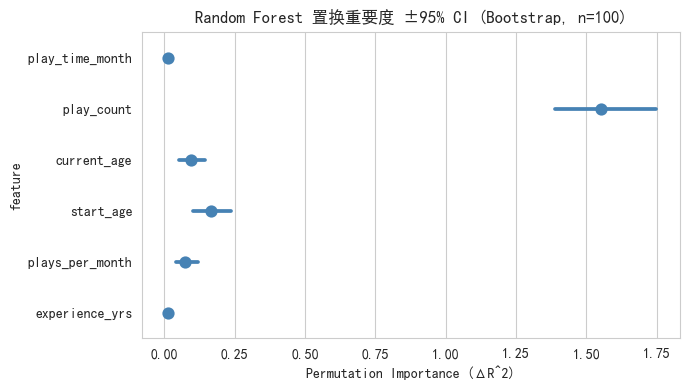

                     mean     lower     upper
feature                                      
play_count       1.553764  1.388235  1.746518
start_age        0.165491  0.103483  0.237707
current_age      0.093669  0.053605  0.145364
plays_per_month  0.073145  0.041213  0.120186
experience_yrs   0.013879  0.007963  0.022151
play_time_month  0.013817  0.008349  0.022665


In [38]:
# -----------------
# 3. 可视化均值 ±95% CI
# -----------------
plt.figure(figsize=(7,4))
sns.pointplot(
    data=imp_df, x="importance", y="feature",
    linestyle='none', estimator=np.mean, errorbar=("pi", 95),
    color="steelblue"
)

plt.xlabel("Permutation Importance (ΔR^2)")
plt.title("Random Forest 置换重要度 ±95% CI (Bootstrap, n=100)")
plt.tight_layout()
plt.show()

# 4. 输出表格（均值 & CI）
summary = imp_df.groupby("feature")["importance"].agg(
    mean="mean",
    lower=lambda x: np.percentile(x, 2.5),
    upper=lambda x: np.percentile(x, 97.5)
).sort_values(by="mean", ascending=False)
print(summary)

C:\Users\24425\AppData\Local\Temp\ipykernel_10224\3876357876.py:29: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
C:\Users\24425\AppData\Local\Temp\ipykernel_10224\3876357876.py:29: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
C:\Users\24425\AppData\Local\Temp\ipykernel_10224\3876357876.py:29: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


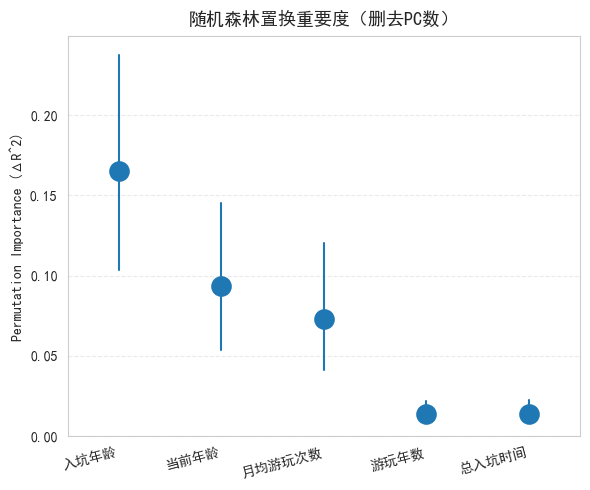

In [45]:
# --------------------------------------------------
# 1⃣  过滤掉 play_count，并映射中文特征名
# --------------------------------------------------
rename_cn = {
    "start_age"       : "入坑年龄",
    "current_age"     : "当前年龄",
    "plays_per_month" : "月均游玩次数",
    "play_time_month" : "总入坑时间",
    "experience_yrs"  : "游玩年数"
}

imp_sub = (
    imp_df[imp_df["feature"] != "play_count"]      # 去掉 play_count
    .replace({"feature": rename_cn})                # 英文列名 → 中文
)

# 排序：按均值由高到低
order = (
    imp_sub.groupby("feature")["importance"]
    .mean()
    .sort_values(ascending=False)
    .index
)

# --------------------------------------------------
# 2⃣  绘图：竖向点 + CI 线
# --------------------------------------------------
plt.figure(figsize=(6,5))
sns.pointplot(
    data=imp_sub,
    x="feature",              # 横轴：中文特征
    y="importance",           # 纵轴：ΔR²
    order=order,
    estimator=np.mean,
    errorbar=("pi", 95),      # 95% 置信区间
    join=False,
    color="#1f77b4",          # 柔和蓝
    markers="o",
    scale=2.0,                # 放大点
    errwidth=1.5,
)

# 美化
plt.ylabel("Permutation Importance (ΔR^2)")
plt.xlabel("")                         # 去掉横轴标签
plt.ylim(0, None)
plt.title("随机森林置换重要度（删去PC数）", fontsize=13, pad=8)
plt.grid(axis="y", ls="--", alpha=0.4)
plt.xticks(rotation=15, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

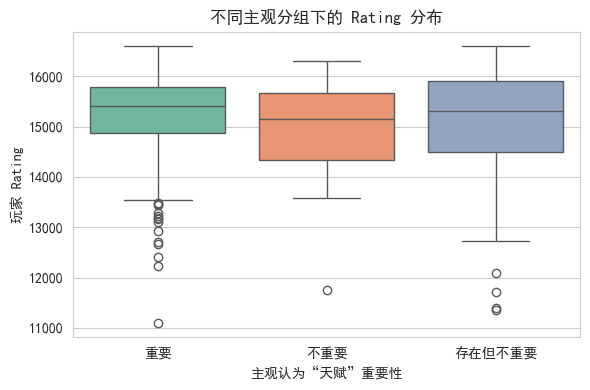

In [10]:
# —— 5. Question1 对比分布 ——
plt.figure(figsize=(6, 4))
# 1) 方式一：不指定 palette，而用 color 指定单色
# sns.boxplot(x="Question1", y="player_rating", data=df, color="skyblue")

# 2) 方式二：如果你还想要不同颜色，需要把 x 也当 hue
sns.boxplot(
    x="Question1",
    y="player_rating",
    hue="Question1",
    data=df,
    palette="Set2",
    dodge=False,      # 保证每个 x 只画一组箱线
    legend=False
)
plt.xticks([0, 1, 2], ["重要", "不重要", "存在但不重要"])
plt.xlabel("主观认为“天赋”重要性")
plt.ylabel("玩家 Rating")
plt.title("不同主观分组下的 Rating 分布")
plt.tight_layout()
plt.show()

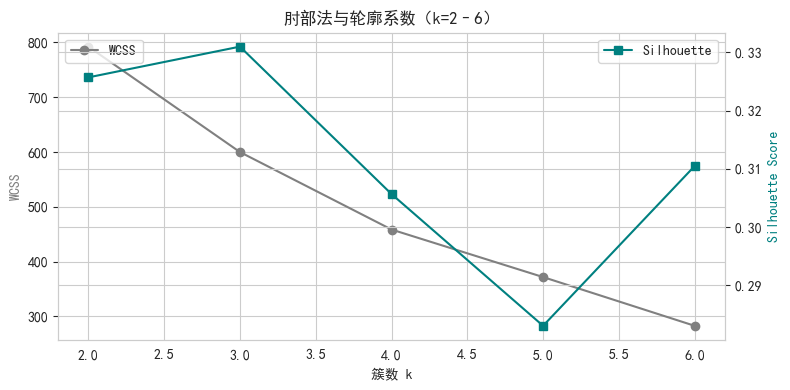

最佳簇数：3


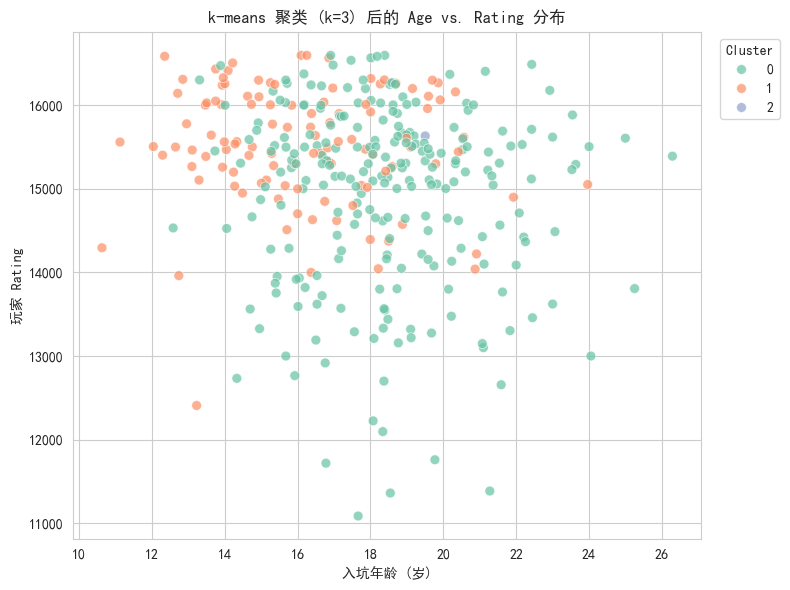

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 准备数据
X = df[['start_age','experience_yrs','play_count']].fillna(0)
Xz = StandardScaler().fit_transform(X)

# 1. 寻找最优 k：肘部法 & 轮廓系数
wcss = []
sil_scores = []
ks = range(2, 7)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42).fit(Xz)
    wcss.append(km.inertia_)
    sil_scores.append(silhouette_score(Xz, km.labels_))

# 可视化肘部法和轮廓系数
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
ax1.plot(ks, wcss, '-o', color='gray', label='WCSS')
ax2.plot(ks, sil_scores, '-s', color='teal', label='Silhouette')
ax1.set_xlabel('簇数 k')
ax1.set_ylabel('WCSS', color='gray')
ax2.set_ylabel('Silhouette Score', color='teal')
plt.title('肘部法与轮廓系数（k=2–6）')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 2. 选取最佳 k（例如 silhouette 最高的 k）
best_k = ks[np.argmax(sil_scores)]
print(f"最佳簇数：{best_k}")

# 3. 基于最佳 k 做 KMeans 并可视化
km_best = KMeans(n_clusters=best_k, random_state=42).fit(Xz)
df['cluster'] = km_best.labels_

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="start_age",
    y="player_rating",
    hue="cluster",
    palette="Set2",
    s=50,
    alpha=0.7
)
plt.xlabel("入坑年龄 (岁)")
plt.ylabel("玩家 Rating")
plt.title(f"k-means 聚类 (k={best_k}) 后的 Age vs. Rating 分布")
plt.legend(title="Cluster", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


In [12]:
import statsmodels.formula.api as smf

for q in [0.1, 0.5, 0.9]:
    qr = smf.quantreg(
        "player_rating ~ play_time_month + play_count + start_age + current_age",
        df
    ).fit(q=q)
    print(f"Quantile {q}:\n", qr.params[["play_count","start_age"]], "\n")


Quantile 0.1:
 play_count      0.079130
start_age     294.969342
dtype: float64 

Quantile 0.5:
 play_count     0.326385
start_age    -37.130873
dtype: float64 

Quantile 0.9:
 play_count     0.303801
start_age    -33.395441
dtype: float64 

